In [1]:
from qutip import *
import numpy as np

In [2]:
# Defining the system Hamiltonian
eps = 0.0    # Energy of the 2-level system.
Del = 0.2    # Tunnelling term
Hsys = 0.5 * eps * sigmaz() + 0.5 * Del * sigmax()
# Initial state of the system.
rho0 = basis(2, 0) * basis(2, 0).dag()
tlist=np.linspace(0,10,1000)

## Spectral density fitting

In [3]:
w = np.linspace(0, 20, 20000)
def ohmic_spectral_density(w, alpha, wc):
    """ The Ohmic bath spectral density as a function of w
        (and the bath parameters).
    """
    return w * alpha * np.e**(-w / wc)

In [31]:
alpha=0.05
T=1
wc=1

In [5]:
J=ohmic_spectral_density(w,alpha,wc)

In [33]:
obp=heom.FitBath(alpha,T,wc,sigmax())

Parameters [k=1]: lam=[0.09458066]; gamma=[1.77943935]; w0=[0.1], Obtain a normalized RMSE of 0.00016082566438015624


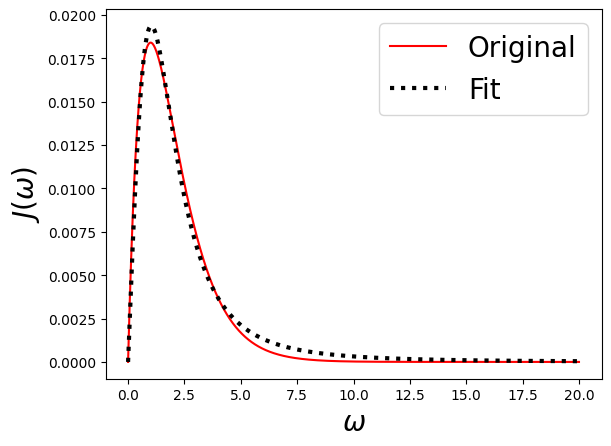

Parameters [k=2]: lam=[0.05021707 0.03401139]; gamma=[1.43484572 1.24938702]; w0=[1.80511587 0.1       ], Obtain a normalized RMSE of 7.935919929349685e-05


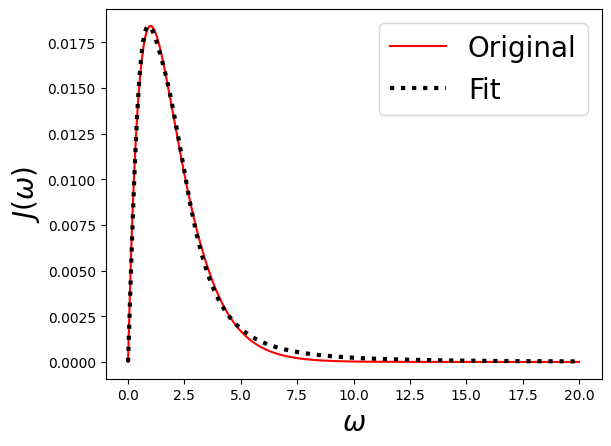

In [7]:
obp.get_fit(J,w,N=False,plots=True,final_rmse=1e-4)

Parameters [k=4]: lam=[-0.0678983   0.00926223  0.12182157  0.00016335]; gamma=[4.30107026 1.0030766  2.29685523 0.30763992]; w0=[3.97689247 0.1        0.1        0.1       ], Obtain a normalized RMSE of 2.308571144699614e-06


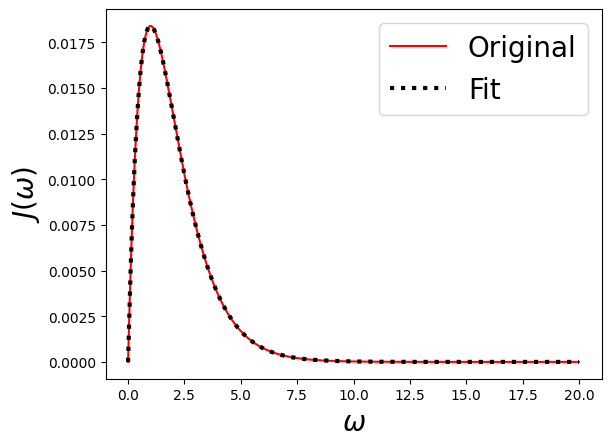

In [8]:
obp.get_fit(J,w,N=4,plots=True)

In [34]:
obp.params_spec = [1], [1], [1]
obp.matsubara_coefficients_from_spectral_fit(Nk=2)
ckAR2, vkAr2, ckAI2, vkAI2 = obp.matsubara_coeff_spec[:-1]
test_terminator = obp.matsubara_coeff_spec[-1].full()

In [35]:
test_terminator

array([[ 0.00010175-0.j,  0.        +0.j,  0.        +0.j,
        -0.00010175+0.j],
       [ 0.        +0.j,  0.00010175-0.j, -0.00010175+0.j,
         0.        +0.j],
       [ 0.        +0.j, -0.00010175+0.j,  0.00010175-0.j,
         0.        +0.j],
       [-0.00010175+0.j,  0.        +0.j,  0.        +0.j,
         0.00010175-0.j]])

In [37]:
 obp.matsubara_coeff_spec[:-1]

([(0.29298628613108785-0.2097848947562078j),
  (0.29298628613108785+0.2097848947562078j),
  (-0.01608448645347298+0j),
  (-0.002015397620259254+0j)],
 [(1-1j), (1+1j), (6.283185307179586+0j), (12.566370614359172+0j)],
 [(-0-0.25j), 0.25j],
 [(1+1j), (1-1j)])

In [30]:
np.isclose(ans_terminator,test_terminator).all()

True

In [21]:
obp.bath.params_spec = [1], [1], [1]

AttributeError: 'FitBath' object has no attribute 'bath'

In [10]:
Ltot = liouvillian(Hsys) + obp.terminator
options = {'nsteps':15000, 'store_states':True, 'rtol':1e-12, 'atol':1e-12, 'method':"bdf"}

In [11]:
HEOM_spectral_fit = heom.HEOMSolver(Ltot, obp.Bath_spec, max_depth=4, options=options,)
result_spectral=HEOM_spectral_fit.run(rho0,tlist)

10.0%. Run time:   1.18s. Est. time left: 00:00:00:10
20.0%. Run time:   2.37s. Est. time left: 00:00:00:09
30.0%. Run time:   3.68s. Est. time left: 00:00:00:08
40.0%. Run time:   4.89s. Est. time left: 00:00:00:07
50.1%. Run time:   6.04s. Est. time left: 00:00:00:06
60.1%. Run time:   7.20s. Est. time left: 00:00:00:04
70.1%. Run time:   8.47s. Est. time left: 00:00:00:03
80.1%. Run time:   9.67s. Est. time left: 00:00:00:02
90.1%. Run time:  10.96s. Est. time left: 00:00:00:01
100.0%. Run time:  12.24s. Est. time left: 00:00:00:00
Total run time:  12.24s


## Correlation Function Fitting

In [12]:
from mpmath import mp


In [13]:
def ohmic_correlation(t, alpha, wc, beta, s=1):
    """ The Ohmic bath correlation function as a function of t
        (and the bath parameters).
    """
    corr = (
        (1 / np.pi) * alpha * wc**(1 - s) * beta**(-(s + 1)) * mp.gamma(s + 1)
    )
    z1_u = (1 + beta * wc - 1.0j * wc * t) / (beta * wc)
    z2_u = (1 + 1.0j * wc * t) / (beta * wc)
    # Note: the arguments to zeta should be in as high precision as possible.
    # See http://mpmath.org/doc/current/basics.html#providing-correct-input
    return np.array([
        complex(corr * (mp.zeta(s + 1, u1) + mp.zeta(s + 1, u2)))
        for u1, u2 in zip(z1_u, z2_u)
    ], dtype=np.complex128)

In [14]:
C=ohmic_correlation(tlist,alpha,wc,1/T)

0.0007850170272317621 0.0007459931927438035
Parameters: 
 [kr=1]: lam=[0.02645534]; gamma=[-1.28893512]; w0=[1.73069104e-12] with normalized RMSE 0.0007850170272317621 
 [ki=1]: lam=[-0.11677207]; gamma=[-1.72572335]; w0=[0.39591075] with normalized 0.0007459931927438035


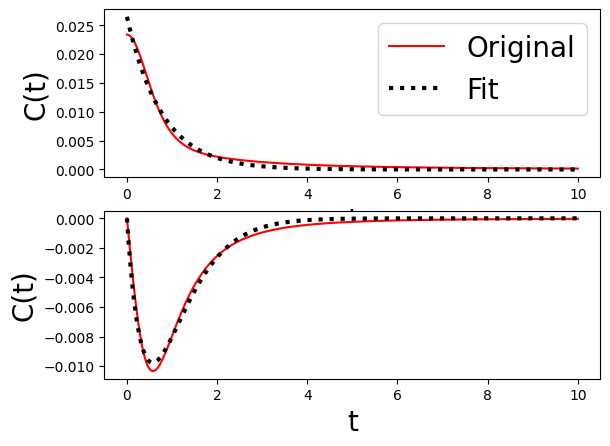

0.00038252526658879524 0.0003543130260187791
Parameters: 
 [kr=2]: lam=[0.0140705 0.0115834]; gamma=[-1.18030216 -0.64307704]; w0=[1.42584122e+00 3.79867762e-19] with normalized RMSE 0.00038252526658879524 
 [ki=2]: lam=[-0.11677207 -0.01399813]; gamma=[-1.23993592 -1.43569016]; w0=[0.14401047 1.80508414] with normalized 0.0003543130260187791


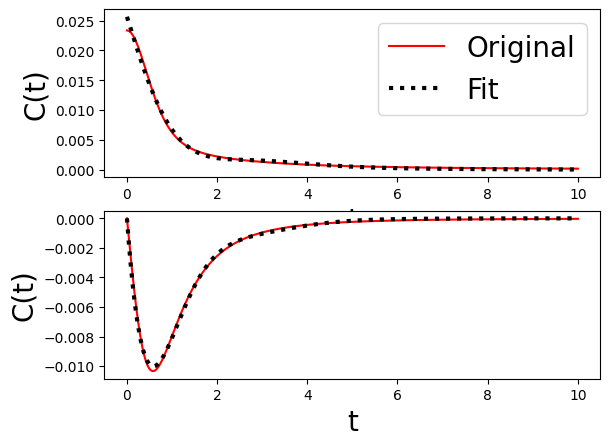

In [15]:
obp.fit_correlation(tlist,C,final_rmse=5e-4)

happened
3.376089578305972e-06 5.419385902718789e-05
Parameters: 
 [kr=4]: lam=[ 0.04446402  0.13064632 -0.1245144  -0.02721077]; gamma=[-2.80451837 -0.39768115 -0.38991104 -4.64012132]; w0=[4.16801101e-01 9.98355639e-05 4.25497734e-02 2.67295373e+00] with normalized RMSE 3.376089578305972e-06 
 [ki=3]: lam=[-0.11677207  0.0054071  -0.11677207]; gamma=[-0.79497337 -4.15641417 -2.08872708]; w0=[0.02253055 4.81914662 0.47960412] with normalized 5.419385902718789e-05


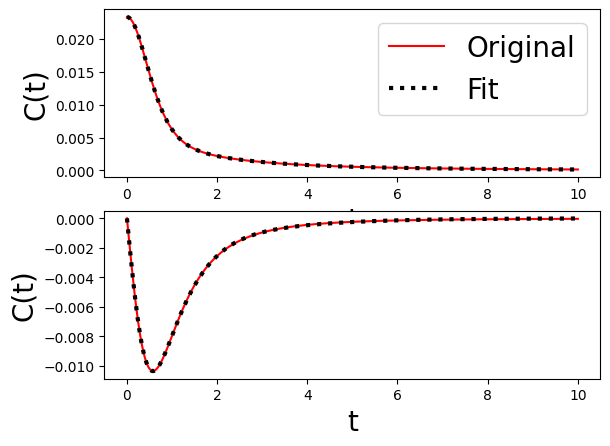

In [16]:
obp.fit_correlation(tlist,C,Ni=3,Nr=4)

In [17]:
obp.matsubara_coefficients();

In [18]:
HEOM_corr_fit = heom.HEOMSolver(Ltot, obp.Bath_corr, max_depth=4, options=options,)
result_corr=HEOM_corr_fit.run(rho0,tlist)

10.0%. Run time:   0.08s. Est. time left: 00:00:00:00
20.0%. Run time:   0.12s. Est. time left: 00:00:00:00
30.0%. Run time:   0.17s. Est. time left: 00:00:00:00
40.0%. Run time:   0.22s. Est. time left: 00:00:00:00
50.1%. Run time:   0.27s. Est. time left: 00:00:00:00
60.1%. Run time:   0.32s. Est. time left: 00:00:00:00
70.1%. Run time:   0.37s. Est. time left: 00:00:00:00
80.1%. Run time:   0.42s. Est. time left: 00:00:00:00
90.1%. Run time:   0.47s. Est. time left: 00:00:00:00
100.0%. Run time:   0.52s. Est. time left: 00:00:00:00
Total run time:   0.52s


# Comparison between fits

In [19]:
def projection(result,i,j):
    return [result.states[k][i,j] for k in range(len(result.states))]

In [20]:
import matplotlib.pyplot as plt

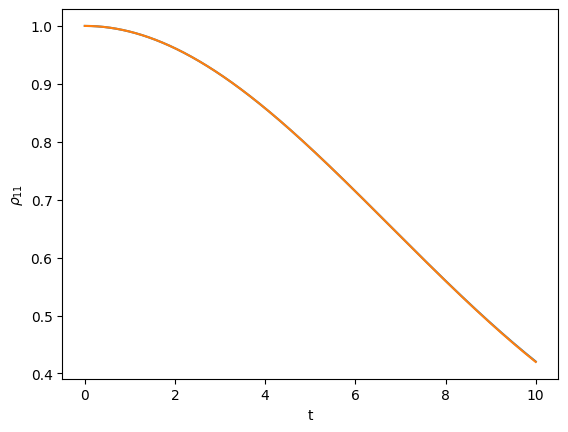

In [29]:
plt.plot(tlist,projection(result_corr,0,0))
plt.plot(tlist,projection(result_spectral,0,0))
plt.xlabel('t')
plt.ylabel(r'$\rho_{11}$')
plt.show()

[]

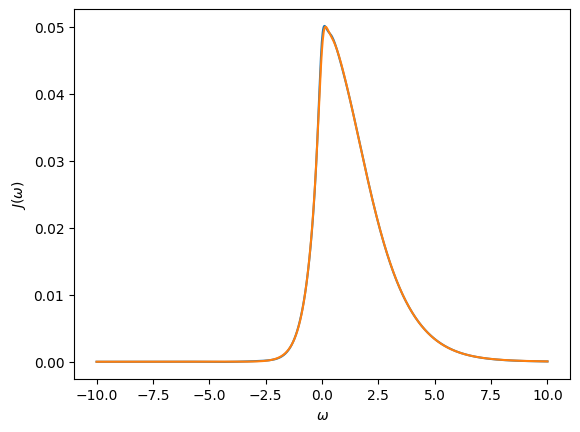

In [28]:
w=np.linspace(-10,10,1000)
plt.plot(w,obp.corr_spectrum_approx(w))
plt.plot(w,obp.spec_spectrum_approx(w))
plt.ylabel(r'$J( \omega )$')
plt.xlabel(r'$\omega$')
plt.show()